In [1]:
print("hello")

hello


In [2]:
import numpy as np
import pathlib
import struct
import pandas as pd
import gc
import os.path
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from tabulate import tabulate
import csv

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

print("Done")

Done


In [3]:
import numpy as np
import pathlib
import struct
import pandas as pd
import gc
import os.path
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from tabulate import tabulate
import csv

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

print("Done")

Done


In [4]:
print(len(tf.config.list_physical_devices('GPU')))

1


In [5]:
direction = pathlib.Path(f'C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Data/Detector97/Shift/Processed')

file_list = list(direction.iterdir())

df = pd.read_hdf(file_list[0],key=None)

print(df.iloc[0:20,9])


0     501.146545
1     494.837341
2     502.828491
3     495.145905
4     495.248596
5     504.253174
6     494.918915
7     503.376556
8     496.066193
9     501.966095
10    494.374420
11    497.305176
12    494.252686
13    499.056183
14    497.104675
15    501.210175
16    502.211761
0     499.976288
1     493.010223
2     500.001587
Name: 0, dtype: float64


In [6]:
direction = pathlib.Path(f'C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Data/Detector97/Shift/Processed')

file_list = list(direction.iterdir())

file_num = len(file_list)

num_test_files = 1
eighty = round(0.8*file_num)
twenty = file_num-eighty - num_test_files

list_of_file_ids_train = np.arange(eighty, dtype=int)

list_of_file_ids_val = np.arange(eighty,eighty+twenty-num_test_files, dtype=int)

list_of_file_ids_test =np.arange(file_num-num_test_files,file_num)


##### Functions to process the data

        ### Unnormalization of each signal individually
def Unnormalized(batch_signals):
        
        return batch_signals
        
        ### Normalization of each signal individually
def Normalized(batch_signals):

        for i in range(len(batch_signals)):
            batch_signals[i] = batch_signals[i]/np.max(batch_signals[i])
            
        return batch_signals
            
        
        ### Normalization of the entire value by one common denominator      
def Denominator(batch_signals):  
    
        denominator = 3953.48
        batch_signals = batch_signals/denominator
        
        return batch_signals


##### Class

class TrainDataset(tf.data.Dataset):

    def _generator(file_id):  
#         print(f'Using Train Class')
        if(file_id == 0):
#             print("reshuffling")
            np.random.shuffle(list_of_file_ids_train)             

        i_file = list_of_file_ids_train[file_id]

#         print(f'file_id: {file_id}, i_file: {i_file}')
#         print()
        signal_filename = direction/f'{i_file+1}.h5'

        
         # Load the labels and signals from the files
        df = pd.read_hdf(signal_filename,key=None)  
        
        labels1 = df.iloc[:,9].values
        labels2 = df['ToF'].values
        labels = labels1+labels2
        
        signals = df[df.columns[10:]].values
        
        
        # Determine how many batches can be made from this file
        num_batches = len(signals) // batch_size

        # Shuffle the signals within the file
        signal_indices = np.arange(len(signals))
        np.random.shuffle(signal_indices)        
        
        # Loop through each batch in the file
        for batch_idx in range(num_batches):
            # Get the signals and labels for this batch
            batch_signal_indices = signal_indices[batch_idx*batch_size:(batch_idx+1)*batch_size]      
 
            batch_signals = signals[batch_signal_indices]
            
            batch_signals = Processing[process](batch_signals)
                
            batch_signals = batch_signals[:,:,np.newaxis] # Can also be done with signals = signals[:,:,np.newaxis]
            batch_labels = labels[batch_signal_indices]

            # Yield the signals and labels as a tuple
            yield batch_signals, batch_labels 
             
    def __new__(cls, file_id):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=(tf.dtypes.float64, tf.dtypes.float64),
            output_shapes=((batch_size, 1980,1), (batch_size, )),
            args=(file_id,)
        )
    
class ValDataset(tf.data.Dataset):

    def _generator(file_id):  
#         print(f'Using Val Class')
        i_file = list_of_file_ids_val[file_id]
    
        signal_filename = direction/f'{i_file+1}.h5'

         # Load the labels and signals from the files
        df = pd.read_hdf(signal_filename,key=None)    
        
        labels1 = df.iloc[:,9].values
        labels2 = df['ToF'].values
        labels = labels1+labels2
        
        signals = df[df.columns[10:]].values
        
        
        # Determine how many batches can be made from this file
        num_batches = len(signals) // batch_size

        # Shuffle the signals within the file
        signal_indices = np.arange(len(signals))
        np.random.shuffle(signal_indices)        
        
        # Loop through each batch in the file
        for batch_idx in range(num_batches):
            # Get the signals and labels for this batch
            batch_signal_indices = signal_indices[batch_idx*batch_size:(batch_idx+1)*batch_size]      
 
            batch_signals = signals[batch_signal_indices]
            
            batch_signals = Processing[process](batch_signals)
                
            batch_signals = batch_signals[:,:,np.newaxis] # Can also be done with signals = signals[:,:,np.newaxis]
            batch_labels = labels[batch_signal_indices]

            # Yield the signals and labels as a tuple
            yield batch_signals, batch_labels
             
    def __new__(cls, file_id):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=(tf.dtypes.float64, tf.dtypes.float64),
            output_shapes=((batch_size, 1980,1), (batch_size, )),
            args=(file_id,)
        )

In [7]:
# model = keras.models.Sequential()
# model.add(Conv1D(filters=16, kernel_size=5,activation='relu', input_shape=(1980, 1)))
# model.add(Conv1D(filters=8, kernel_size=5,dilation_rate=2,activation='relu'))
# model.add(BatchNormalization())
# model.add(Conv1D(filters=4, kernel_size=5,dilation_rate=2,activation='relu'))
# model.add(Conv1D(filters=4, kernel_size=5,strides=2,activation='relu'))
# model.add(BatchNormalization())
# model.add(Conv1D(filters=4, kernel_size=3,strides=2))
# model.add(Flatten())
# model.add(Dense(32,activation='relu'))
# model.add(Dense(16,activation='relu'))
# model.add(Dense(1))

# print(model.summary())


In [8]:
def create_model():
    model = keras.models.Sequential()
    model.add(Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=(1980, 1)))
    model.add(Conv1D(filters=8, kernel_size=5, dilation_rate=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=4, kernel_size=5, dilation_rate=2, activation='relu'))
    model.add(Conv1D(filters=4, kernel_size=5, strides=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=4, kernel_size=3, strides=2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

In [9]:
# Pre-processing options
Processing = {
    "Unnormalized": Unnormalized,
    "Normalized": Normalized,
    "Denominator": Denominator
}
Process = ["Unnormalized","Normalized","Denominator"]
process = Process[2]
# Loss Function

loss_function = ['mean_absolute_error','mean_squared_error']
lf = 1

# Training Variables
batch_size = 32
num_epochs = 30

steps_per_epoch = eighty*5000 // batch_size

# Learning Rate
initial_lr = 1e-03
final_lr = 1e-06

# initial_lr = 1e-03
# final_lr = 1e-03

def step_decay(epoch):
    lrate = initial_lr * (final_lr/initial_lr)**(epoch/num_epochs)

    print(f'Current Learning rate: {lrate}')
    return lrate

# Compile the model
# model.compile(loss=loss_function[lf], optimizer = keras.optimizers.Adam(initial_lr), metrics=['mean_absolute_error','mean_squared_error'])

# Configuring training dataset
dataset_train = tf.data.Dataset.range(eighty).interleave(
        TrainDataset,
        cycle_length=2,
        num_parallel_calls=2,
        deterministic=True).repeat().prefetch(1)



# Configuring training dataset
dataset_val = tf.data.Dataset.range(twenty-num_test_files).interleave(
        ValDataset,
        cycle_length=2,
        num_parallel_calls=2,
        deterministic=True).prefetch(1)


# Callback Functions
LRS = tf.keras.callbacks.LearningRateScheduler(step_decay)

ES = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True,verbose=1)

CSV = tf.keras.callbacks.CSVLogger("C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Data/Log.csv",
                                separator=",", append=True)

MC_path = f"C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Trainings/model_checkpoint.h5"
MC = ModelCheckpoint(
    filepath=MC_path,  # Filepath to save the model weights
    monitor='val_loss',  # Quantity to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model based on the monitored quantity
    save_weights_only=True  # Save only the model weights, not the entire model
)

callbacks = [MC,LRS,CSV]




Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [10]:
num_runs = 3  # Number of times to run the model

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    
    model = create_model()
    
    model.compile(loss=loss_function[lf], optimizer = keras.optimizers.Adam(initial_lr), metrics=['mean_absolute_error','mean_squared_error'])
    
    MC_path = f"C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Trainings/model_checkpoint_{run + 1}.h5"
    MC = ModelCheckpoint(
    filepath=MC_path,  # Filepath to save the model weights
    monitor='val_loss',  # Quantity to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model based on the monitored quantity
    save_weights_only=True  # Save only the model weights, not the entire model
    )

    callbacks = [MC,LRS,CSV]
    
    # Train the model
    history = model.fit(x=dataset_train, validation_data = dataset_val, steps_per_epoch=steps_per_epoch, epochs=num_epochs,callbacks=callbacks)

Run 1/3
Epoch 1/30
Current Learning rate: 0.001
5000/5000 [==============================] - 65s 10ms/step - loss: 991.7848 - mean_absolute_error: 3.5616 - mean_squared_error: 991.7848 - val_loss: 0.1493 - val_mean_absolute_error: 0.2646 - val_mean_squared_error: 0.1493
Epoch 2/30
Current Learning rate: 0.0007943282347242815
5000/5000 [==============================] - 39s 8ms/step - loss: 5.0310 - mean_absolute_error: 0.7365 - mean_squared_error: 5.0310 - val_loss: 0.1212 - val_mean_absolute_error: 0.2743 - val_mean_squared_error: 0.1212
Epoch 3/30
Current Learning rate: 0.0006309573444801933
5000/5000 [==============================] - 48s 10ms/step - loss: 0.5309 - mean_absolute_error: 0.5823 - mean_squared_error: 0.5309 - val_loss: 1.5709 - val_mean_absolute_error: 1.2172 - val_mean_squared_error: 1.5709
Epoch 4/30
Current Learning rate: 0.0005011872336272722
5000/5000 [==============================] - 38s 8ms/step - loss: 0.3904 - mean_absolute_error: 0.4973 - mean_squared_error:

Run 2/3
Epoch 1/30
Current Learning rate: 0.001
5000/5000 [==============================] - 60s 10ms/step - loss: 1577.0276 - mean_absolute_error: 5.6939 - mean_squared_error: 1577.0276 - val_loss: 1.7151 - val_mean_absolute_error: 1.2008 - val_mean_squared_error: 1.7151
Epoch 2/30
Current Learning rate: 0.0007943282347242815
5000/5000 [==============================] - 46s 9ms/step - loss: 0.8729 - mean_absolute_error: 0.7399 - mean_squared_error: 0.8729 - val_loss: 0.9218 - val_mean_absolute_error: 0.9227 - val_mean_squared_error: 0.9218
Epoch 3/30
Current Learning rate: 0.0006309573444801933
5000/5000 [==============================] - 57s 11ms/step - loss: 0.6850 - mean_absolute_error: 0.6483 - mean_squared_error: 0.6850 - val_loss: 0.0527 - val_mean_absolute_error: 0.1913 - val_mean_squared_error: 0.0527
Epoch 4/30
Current Learning rate: 0.0005011872336272722
5000/5000 [==============================] - 47s 9ms/step - loss: 0.4615 - mean_absolute_error: 0.5417 - mean_squared_erro

5000/5000 [==============================] - 43s 8ms/step - loss: 0.0333 - mean_absolute_error: 0.1435 - mean_squared_error: 0.0333 - val_loss: 0.0220 - val_mean_absolute_error: 0.1215 - val_mean_squared_error: 0.0220
Run 3/3
Epoch 1/30
Current Learning rate: 0.001
5000/5000 [==============================] - 61s 10ms/step - loss: 2258.4524 - mean_absolute_error: 8.8459 - mean_squared_error: 2258.4524 - val_loss: 4.5867 - val_mean_absolute_error: 1.8774 - val_mean_squared_error: 4.5867
Epoch 2/30
Current Learning rate: 0.0007943282347242815
5000/5000 [==============================] - 46s 9ms/step - loss: 1.1135 - mean_absolute_error: 0.8235 - mean_squared_error: 1.1135 - val_loss: 4.9169 - val_mean_absolute_error: 2.2092 - val_mean_squared_error: 4.9169
Epoch 3/30
Current Learning rate: 0.0006309573444801933
5000/5000 [==============================] - 65s 13ms/step - loss: 0.3891 - mean_absolute_error: 0.4912 - mean_squared_error: 0.3891 - val_loss: 1.9719 - val_mean_absolute_error: 

Epoch 30/30
Current Learning rate: 1.2589254117941674e-06
5000/5000 [==============================] - 52s 10ms/step - loss: 0.0203 - mean_absolute_error: 0.1090 - mean_squared_error: 0.0203 - val_loss: 0.0155 - val_mean_absolute_error: 0.0955 - val_mean_squared_error: 0.0155


In [11]:
model.load_weights(MC_path)

Train Lowest: 0.020310338586568832
Val Lowest: 0.015520723536610603


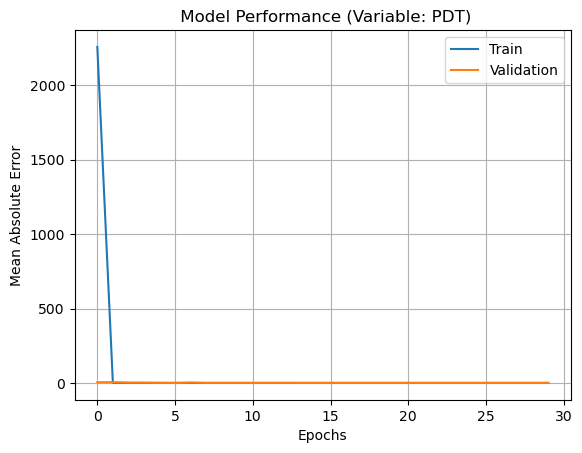

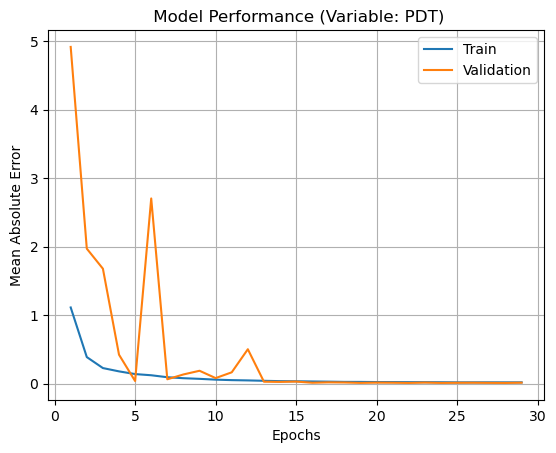

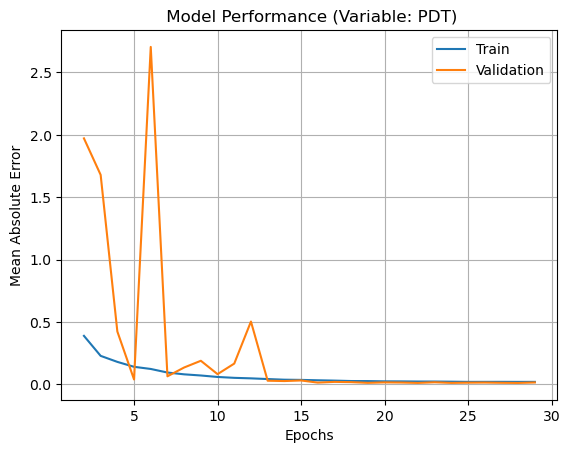

In [12]:
##### All Analysis Tools:::

# Loss/Val vs Epochs
loss = history.history['loss']
val = history.history['val_loss']

x1 = np.arange(1,len(loss))
x2 = np.arange(2,len(loss))

# print(f'Training: {loss} \n')
# print(f'Validation: {val}')

print(f'Train Lowest: {loss[-1]}')
print(f'Val Lowest: {val[-1]}')

# Full Training
plt.plot(loss,label='Train')
plt.title(f' Model Performance (Variable: PDT)')
plt.plot(val,label='Validation')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

# Full training without first epoch
plt.plot(x1,loss[1:],label='Train')
plt.plot(x1,val[1:],label='Validation')
plt.title(f' Model Performance (Variable: PDT)')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

# Full training without first two epochs
plt.plot(x2,loss[2:],label='Train')
plt.plot(x2,val[2:],label='Validation')
plt.title(f' Model Performance (Variable: PDT)')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

In [13]:
avg_loss = []


for i in list_of_file_ids_test:
    df = pd.read_hdf(file_list[i],key=None)   

    labels1 = df.iloc[:,9].values
    labels2 = df['ToF'].values
    labels = labels1+labels2

    signals = df[df.columns[10:]].values
    signals = Processing[process](signals)
    signals = signals[:,:,np.newaxis]

    # model.predict
    predicted = model.predict(signals)
    predicted = np.squeeze(predicted) # getting rid of extra dimension
    true = labels
    
    test_loss = np.subtract(predicted,true)
    
    avg_test_loss = np.mean(np.abs(test_loss))
    print(avg_test_loss)
    avg_loss.append(avg_test_loss)
    
print(f'Mean Absolute Error: {np.mean(avg_loss)}')

0.07980263619194462
Mean Absolute Error: 0.07980263619194462


In [14]:
avg_loss = []


for i in list_of_file_ids_test:
    df = pd.read_hdf(file_list[i],key=None)   

    labels1 = df.iloc[:,9].values
    labels2 = df['ToF'].values
    labels = labels1+labels2

    signals = df[df.columns[10:]].values
    signals = Processing[process](signals)
    signals = signals[:,:,np.newaxis]
    
    # model.predict
    predicted = model.predict(signals)
    predicted = np.squeeze(predicted)  # getting rid of extra dimension
    true = labels
    
    test_loss = np.subtract(predicted, true)
    
    # Calculate mean squared error (MSE)
    mse = np.mean(np.square(test_loss))
    print("Mean Squared Error:", mse)
    
    avg_loss.append(mse)
    
print(f'Mean Squared Error: {np.mean(avg_loss)}')

Mean Squared Error: 0.011258951772217755
Mean Squared Error: 0.011258951772217755


In [15]:
# print(list_of_file_ids_test)

# df_test = pd.concat([pd.read_hdf(file_list[i], key=None) for i in list_of_file_ids_test])
# unique_mass_test = df_test['A'].unique()

# result_dict = {}  # Dictionary to store unique_mass and corresponding avg_test_loss values

# # Test Set
# for mass_test in unique_mass_test:
#     print(f"Unique Mass: {mass_test}")
#     df_intermediate = df_test[df_test['A'] == mass_test]
#     unique_energy = df_intermediate['Z'].unique()

#     avg_test_loss_list = []  # List to store avg_test_loss values for each unique_mass
#     count_dict = {}  # Dictionary to store count for each unique_mass and unique_energy pair

#     for energy in unique_energy:
#         print(f"Unique Energy: {energy}")
#         loss = []
#         count = 0
#         for file_id in list_of_file_ids_test:
#             file = file_list[file_id]
#             df = pd.read_hdf(file, key=None)

#             df_intermediate = df[df['A'] == mass_test]
#             df_filtered = df_intermediate[df_intermediate['Z'] == energy]

#             signals = df_filtered[df_filtered.columns[10:]].values
#             signals = Processing[process](signals)
#             signals = signals[:, :, np.newaxis]

#             predicted = model.predict(signals)
#             predicted = np.squeeze(predicted)

#             labels1 = df_filtered.iloc[:, 9].values
#             labels2 = df_filtered['ToF'].values
#             true = labels1 + labels2

#             test_loss = predicted - true
#             avg_test_loss = np.mean(np.abs(test_loss))
#             loss.append(avg_test_loss)
            
#             count += len(df_filtered)

#         avg_test_loss_list.append(np.mean(loss))
#         count_dict[energy] = count
    
#     result_dict[mass_test] = {
#         'unique_energy': unique_energy,
#         'avg_test_loss': avg_test_loss_list,
#         'count': count_dict
#     }

# # Print the result dictionary
# for mass, result in result_dict.items():
#     unique_energy = result['unique_energy']
#     avg_test_loss_list = result['avg_test_loss']
#     count_dict = result['count']
#     for energy, avg_test_loss in zip(unique_energy, avg_test_loss_list):
#         print(f"Unique Mass: {mass}, Unique Energy: {energy}")
#         print(f"Avg Test Loss: {avg_test_loss}")
#         print(f"Count: {count_dict[energy]}")
#     print()

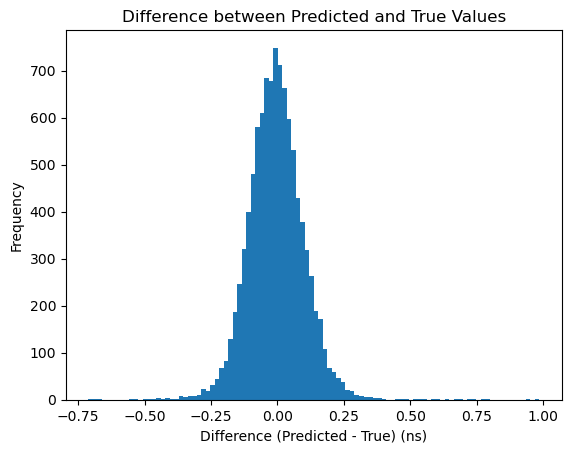

In [16]:
# Concatenate the test files into a single DataFrame
df_test = pd.concat([pd.read_hdf(file_list[file_id], key=None) for file_id in list_of_file_ids_test])

labels1 = df_test.iloc[:, 9].values
labels2 = df_test['ToF'].values
labels = labels1 + labels2

signals = df_test[df_test.columns[10:-2]].values
signals = Processing[process](signals)
signals = signals[:, :, np.newaxis]

# model.predict
predicted = model.predict(signals)
predicted = np.squeeze(predicted)  # getting rid of extra dimension
true = labels

difference = predicted - true
# Plotting the histogram
plt.hist(difference, bins=100)
plt.title("Difference between Predicted and True Values")
plt.xlabel("Difference (Predicted - True) (ns)")
plt.ylabel("Frequency")
plt.show()

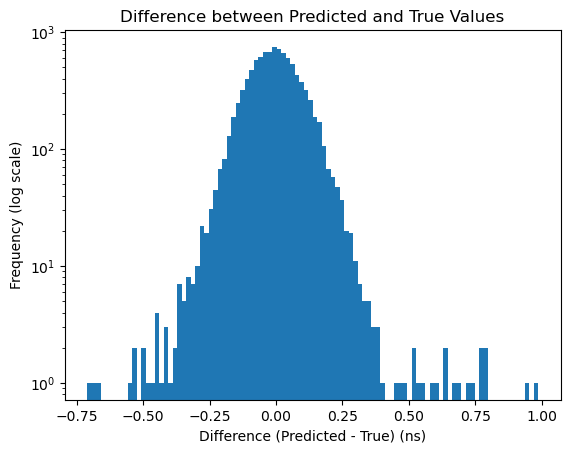

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Concatenate the test files into a single DataFrame
df_test = pd.concat([pd.read_hdf(file_list[file_id], key=None) for file_id in list_of_file_ids_test])

labels1 = df_test.iloc[:, 9].values
labels2 = df_test['ToF'].values
labels = labels1 + labels2

signals = df_test[df_test.columns[10:-2]].values
signals = Processing[process](signals)
signals = signals[:, :, np.newaxis]

# model.predict
predicted = model.predict(signals)
predicted = np.squeeze(predicted)  # getting rid of extra dimension
true = labels

difference = predicted - true

# Plotting the histogram with log scale on y-axis
plt.hist(difference, bins=100)
plt.yscale('log')  # Set log scale on y-axis
plt.title("Difference between Predicted and True Values")
plt.xlabel("Difference (Predicted - True) (ns)")
plt.ylabel("Frequency (log scale)")
plt.show()